In [4]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

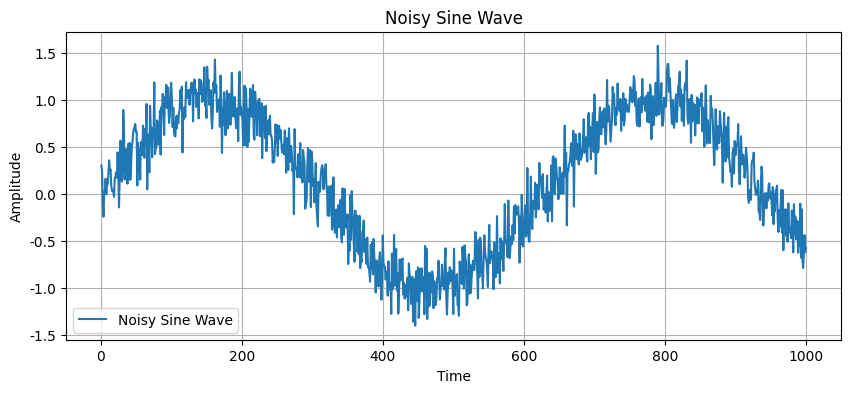

In [5]:
T = 1000  # 总共产生1000个点
# 生成1000个点 torch.arange不包含结束值
time = torch.arange(1, T + 1, dtype=torch.float32)
# torch.normal(0, 0.2, (T,)) 生成一个均值为0，标准差为0.2，形状为 (T,) 的正态分布噪声
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
# 绘图方法
plt.figure(figsize=(10, 4))
plt.plot(time.numpy(), x.numpy(), label='Noisy Sine Wave')
plt.title('Noisy Sine Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# 数据集生成代码

# 表示滞后的时间长度
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    # 将 x 张量中从第 i 个元素到第 T - tau + i 个元素的子序列赋值给 features 张量的第 i 列。
    features[:, i] = x[i: T - tau + i]
# 标签集 从第tau+1个开始
labels = x[tau:].reshape((-1, 1))

时间序列数据：
数据集包含1000个时间点的正弦波信号，其中添加了噪声。
正弦波信号的公式为 x = sin(0.01 * time) + noise，其中 noise 是均值为0、标准差为0.2的正态分布噪声。

滞后时间点 (tau)：
滞后时间点的长度 tau 设置为4。这意味着我们将使用前4个时间点的值作为特征来预测当前时间点的值。

特征矩阵 (features)：
特征矩阵的形状为 (T - tau, tau)，其中 T 是总时间点数（1000），tau 是滞后时间点长度（4）。
每个样本的特征包含前4个时间点的值。例如，特征矩阵的第一行包含时间点1到时间点4的值，第二行包含时间点2到时间点5的值，依此类推。

标签 (labels)：
标签是每个样本的当前时间点的值，用于预测。
标签的形状为 (T - tau, 1)，即每个样本只有一个标签值。


In [7]:
# 分割训练集和测试集
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
# is_train=True 参数表示这是一个训练数据集。
# 返回一个torch.utils.data.DataLoader对象
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

复习

ReLu:
当输入为正数或零时，输出等于输入值
当输入为负数时，输出为0

MSE = (1/n) * Σ(y_true - y_pred)²


In [8]:
# 使用一个简单的结构 拥有两个全连接层的多层感知机，ReLU激活函数和平方损失
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')
# net() 函数的输入是一个形状为 (batch_size, 4) 的张量：

In [9]:
# 训练模型
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.057283
epoch 2, loss: 0.052365
epoch 3, loss: 0.050061
epoch 4, loss: 0.049782
epoch 5, loss: 0.048491
epoch 6, loss: 0.049311
epoch 7, loss: 0.051466
epoch 8, loss: 0.050838
epoch 9, loss: 0.047548
epoch 10, loss: 0.047816


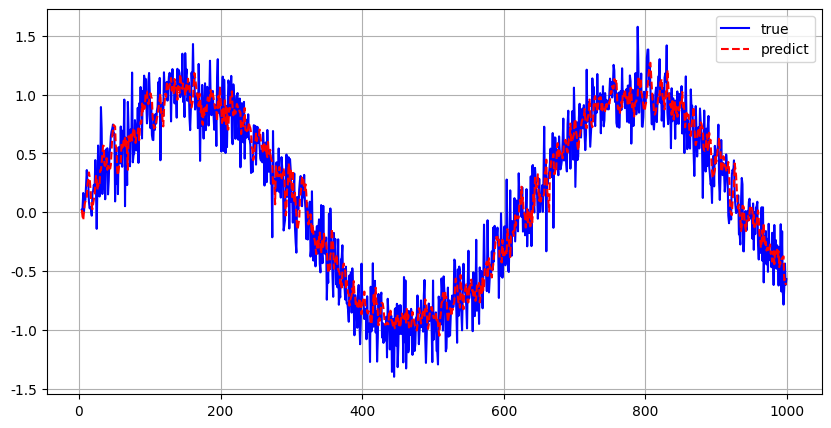

In [11]:
# 进行单步预测 输入前四个时间步的数值 输出这个时间步的数值
def plot_next_step_prediction(net, features, labels, tau, T):
    # 预测所有时间步
    with torch.no_grad():
        # net() 函数的输入是一个形状为 (batch_size, 4) 的张量
        # 输出是一个形状为 (batch_size, 1) 的张量
        pred = net(features).reshape(-1)
    time_steps = torch.arange(tau, T, dtype=torch.float32) 
    
    plt.figure(figsize=(10, 5))
    
    # 绘制真实值
    plt.plot(time_steps.numpy(), labels.reshape(-1).numpy(), 
             'b-', label='data')
    
    # 绘制预测值
    plt.plot(time_steps.numpy(), pred.numpy(), 
             'r--', label='predict')
    
    # 添加图例和标签
    plt.legend()
    plt.grid(True)

    plt.show()

# 执行预测可视化
plot_next_step_prediction(net, features, labels, tau, T)
# features 是一个形状为 (996, 4) 的张量

In [12]:
# 进行多步预测
# 创建一个长度为T的零张量
multistep_preds = torch.zeros(T)
# 将前n_train + tau个实际观测值复制到预测数组
multistep_preds[: n_train + tau] = x[: n_train + tau]
# 使用预测值作为新的输入 不断将预测到的值保存在列表中
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

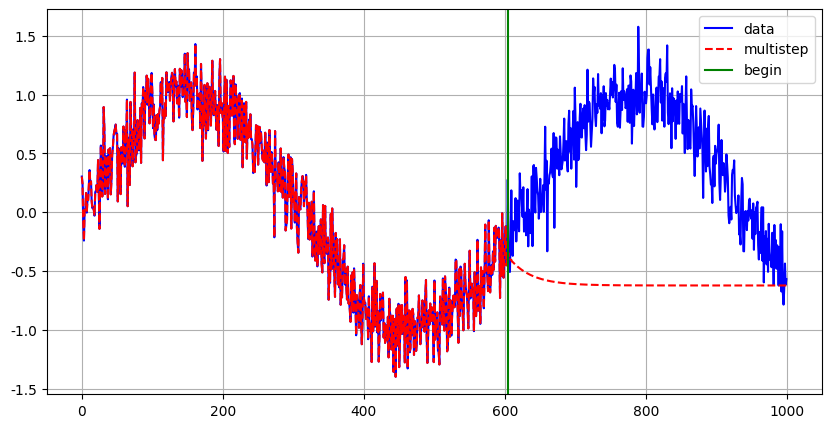

In [14]:
# 多步预测展示
# 扰动会不断叠加 以至于后面趋向于常数
def plot_multistep_prediction(multistep_preds, x, n_train, tau, T):
    # 创建时间步数组
    time_steps = torch.arange(T, dtype=torch.float32)
    
    plt.figure(figsize=(10, 5))
    
    # 绘制原始数据
    plt.plot(time_steps.numpy(), x.numpy(), 
             'b-', label='data')
    
    plt.plot(time_steps.numpy(), multistep_preds.detach().numpy(), 
             'r--', label='multistep')
    
    # 标记预测起始点
    plt.axvline(x=n_train + tau, color='green', linestyle='-', 
                label='begin')
    
    # 添加图例和标签
    plt.legend()
    plt.grid(True)
    
    plt.show()

# 使用方法
plot_multistep_prediction(multistep_preds, x, n_train, tau, T)

In [16]:
# k步预测
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

# 填充观测值
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 生成预测值
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

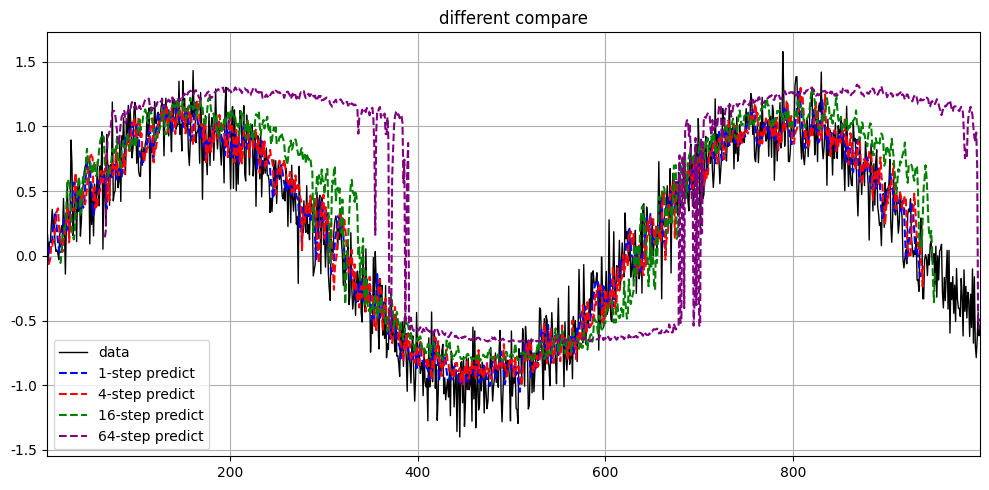

In [19]:
def plot_k_step_predictions(features, x, tau, T, max_steps, steps=(1, 4, 16, 64)):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 创建时间步数组
    time_steps = np.arange(T)
    
    plt.figure(figsize=(10, 5))
    
    # 绘制原始数据
    plt.plot(time_steps, x.detach().numpy(), 
             'k-', linewidth=1, label='data')
    
    # 为不同的预测步长设置不同的颜色
    colors = ['blue', 'red', 'green', 'purple']
    
    # 绘制不同步长的预测结果
    for idx, step in enumerate(steps):
        # 计算此步长预测值对应的时间点
        pred_time = np.arange(tau + step - 1, T - max_steps + step)
        
        # 获取对应的预测值 
        # features矩阵从第5列开始 每一列都可以视为step步的预测值
        # 第五列就是预测一步的所有预测值
        pred_values = features[:, tau + step - 1].detach().numpy()
        
        # 绘制预测结果
        plt.plot(pred_time, pred_values, 
                 color=colors[idx % len(colors)], linestyle='--', 
                 label=f'{step}-step predict')
    
    # 添加图例和标签
    plt.legend()
    plt.title('different compare')
    plt.grid(True)
    
    # 设置x轴范围（可选）
    plt.xlim([5, T-1])
    
    plt.tight_layout()
    plt.show()

# 使用示例
plot_k_step_predictions(features, x, tau, T, max_steps)


## 数据集生成

In [21]:
# 数据集生成模拟 用于理解上述代码
import torch
# 上述代码的简单demo
# 生成一个较小的时间序列
T = 10  # 总共产生10个点
tau = 4  # 滞后时间长度
x = torch.sin(0.01 * torch.arange(1, T + 1, dtype=torch.float32)) + torch.normal(0, 0.2, (T,))

print("生成原始时间序列:")
print(x)

# 生成特征和标签
features = torch.zeros((T - tau, tau))
#
for i in range(tau):
    # 每次对一列进行赋值
    features[:, i] = x[i: T - tau + i]
    print(f"\nStep {i+1}:")
    print(features)

labels = x[tau:].reshape((-1, 1))

# 打印最终的特征和标签
print("\nFinal Features:")
print(features)
print("\nLabels:")
print(labels)

生成原始时间序列:
tensor([-0.0647,  0.2650,  0.0032, -0.1375,  0.0519, -0.1999,  0.2682,  0.3420,
         0.2979,  0.3156])

Step 1:
tensor([[-0.0647,  0.0000,  0.0000,  0.0000],
        [ 0.2650,  0.0000,  0.0000,  0.0000],
        [ 0.0032,  0.0000,  0.0000,  0.0000],
        [-0.1375,  0.0000,  0.0000,  0.0000],
        [ 0.0519,  0.0000,  0.0000,  0.0000],
        [-0.1999,  0.0000,  0.0000,  0.0000]])

Step 2:
tensor([[-0.0647,  0.2650,  0.0000,  0.0000],
        [ 0.2650,  0.0032,  0.0000,  0.0000],
        [ 0.0032, -0.1375,  0.0000,  0.0000],
        [-0.1375,  0.0519,  0.0000,  0.0000],
        [ 0.0519, -0.1999,  0.0000,  0.0000],
        [-0.1999,  0.2682,  0.0000,  0.0000]])

Step 3:
tensor([[-0.0647,  0.2650,  0.0032,  0.0000],
        [ 0.2650,  0.0032, -0.1375,  0.0000],
        [ 0.0032, -0.1375,  0.0519,  0.0000],
        [-0.1375,  0.0519, -0.1999,  0.0000],
        [ 0.0519, -0.1999,  0.2682,  0.0000],
        [-0.1999,  0.2682,  0.3420,  0.0000]])

Step 4:
tensor([[-0.0647

## k步预测特征矩阵的生成

### 简单例子

In [28]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
# 序列长度
T = len(x)
# 输入窗口
tau = 2
# 最大预测步数
max_steps = 3 

# 计算矩阵尺寸
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 行数 = 10 - 2 - 3 + 1 = 6 列数 = 2 + 3 = 5
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
print("填充观测值")
print(features)

填充观测值
tensor([[1., 2., 0., 0., 0.],
        [2., 3., 0., 0., 0.],
        [3., 4., 0., 0., 0.],
        [4., 5., 0., 0., 0.],
        [5., 6., 0., 0., 0.],
        [6., 7., 0., 0., 0.]])


In [29]:
# 定义简单预测模型 (预测值 = 最后一个输入值 + 1)
class SimpleModel:
    def __call__(self, window):
        # 提取输入窗口的最后一个值
        last_value = window[:, -1]
        # 预测 = 最后一个值 + 1
        return last_value + 1
# 模型的输入时(batchsize,2) 输出是(batchsize,)
# 创建模型实例
net = SimpleModel()

In [30]:
# 填充预测值（后max_steps列）
for i in range(tau, tau + max_steps):
    input_window = features[:, i-tau:i]  # 形状为 [6, 2]
    features[:, i] = net(input_window)   # 模型输出形状为 [6]

print("\n填充预测值后:")
print(features)

# 第一次循环i=2时 input_window = features[:, 0:2] = 选择0列和1列
# 输入模型后 返回的值即2列的值 这样就相当于每一行的内容进行了1步预测
# 第一次循环i=3时 input_window = features[:, 1:3] = 选择1列和2列
# 输入模型后 返回的值即3列的值 相当于又预测了异步


填充预测值后:
tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 2.,  3.,  4.,  5.,  6.],
        [ 3.,  4.,  5.,  6.,  7.],
        [ 4.,  5.,  6.,  7.,  8.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 6.,  7.,  8.,  9., 10.]])


## 补充

多步预测 (plot_multistep_prediction)：

从单一起点开始连续预测，每一步都使用前面的预测值作为下一步输入，误差会累积传播。

k步预测 (plot_k_step_predictions)：

从多个起点进行固定步长预测，每个预测点都只是原始起点向前k步，误差不会累积，相当于多次"独立"的k步预测。

所以k步预测能够跟随原曲线，而多步预测会趋于直线的